In [1]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 16 × AMD Ryzen 7 PRO 4750U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 2 on 16 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [8]:
using Flux, Statistics, ProgressMeter, Random;
using Fmt, Data;

In [10]:
# Generate some data for the XOR problem: vectors of length 2, as columns of a matrix:
Random.seed!(12)
noisy = rand(Float32, 2, 1000)                                    # 2×1000 Matrix{Float32}
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(noisy)]   # 1000-element Vector{Bool}
println(Fmt.format(f"{x}/{y} is 1.", x = sum(truth), y = length(truth)) )

468/1000 is 1.


In [28]:
# Define our model, a multi-layer perceptron with one hidden layer of size 3:
model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax) |> gpu        # move model to GPU, if available

# The model encapsulates parameters, randomly initialised. Its initial output is:
@time out1 = model(noisy |> gpu) |> cpu # 2×1000 Matrix{Float32}, first row is prob(true), second row p(false)
display(out1)
println(Fmt.format(f"The accuracy is {x}", x=mean((out1[1,:] .> 0.5) .== truth) ) )  # accuracy 94% so far!

  0.000080 seconds (22 allocations: 64.516 KiB)


2×1000 Matrix{Float32}:
 0.436223  0.401529  0.406361  0.465181  …  0.446709  0.434761  0.460167
 0.563777  0.598471  0.593639  0.534819     0.553291  0.565239  0.539833

The accuracy is 0.563


In [29]:
model

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [16]:
# To train the model, we use batches of 64 samples, and one-hot encoding:
target = Flux.onehotbatch(truth, [true, false])                   # 2×1000 OneHotMatrix
loader = Flux.DataLoader((noisy, target) |> gpu, batchsize=64, shuffle=true);
# 16-element DataLoader with first element: (2×64 Matrix{Float32}, 2×64 OneHotMatrix)

In [30]:
optim = Flux.setup(Flux.Adam(0.01), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 1000 times:
loss_v = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(loss_v, loss)  # logging, outside gradient context
    end
end

display(optim) # parameters, momenta and output have all changed

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00620595 0.0463159; 0.0090643 0.0345374; 0.0111884 0.013503], Float32[0.00506529 0.756855; 0.00963903 0.00983399; 0.0184883 0.00864337], (2.5e-323, 1.11526e-7))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.00763842, 0.0573533, 0.00478753], Float32[0.00490702, 0.0344628, 0.0370911], (2.5e-323, 1.11526e-7))), σ = ()), (λ = (), β = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.0319365, 0.0256712, -0.0267973], Float32[0.0431363, 0.0292088, 0.0303284], (2.5e-323, 1.11526e-7))), γ = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.0368198, 0.0210027, 0.014333], Float32[0.0178366, 0.0136609, 0.017324], (2.5e-323, 1.11526e-7))), μ = (), σ² = (), ϵ = (), momentum = (), affine = (), track_stats = (), active = (), chs = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[-0.0290571 -0.0191299 0.0120798; 0.0290571 0.0191299 -0.0120798], Float32[0.011

In [24]:
# prediction
@time out2 = model(noisy |> gpu) |> cpu  # first row is prob. of true, second row p(false)
# 
println(Fmt.format(f"The accuracy is {x}", x=mean((out2[1,:] .> 0.5) .== truth) ) )  # accuracy 94% so far!

  0.001309 seconds (22 allocations: 64.516 KiB)
The accuracy is 0.953


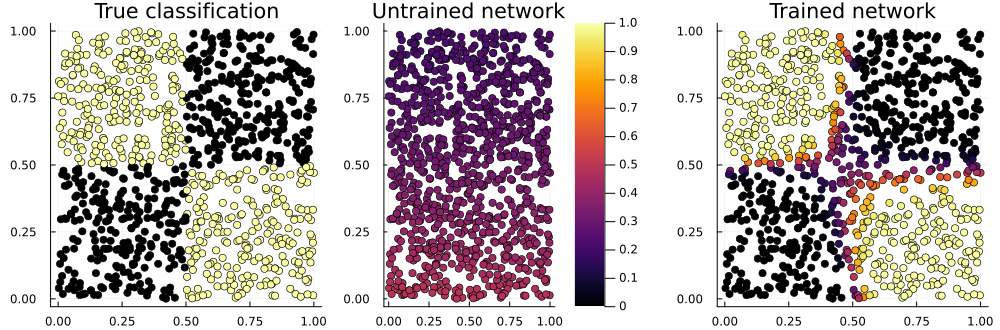

In [25]:
using Plots  # to draw the above figure

p_true = scatter(noisy[1,:], noisy[2,:], zcolor=truth, title="True classification", legend=false)
p_raw =  scatter(noisy[1,:], noisy[2,:], zcolor=out1[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter(noisy[1,:], noisy[2,:], zcolor=out2[1,:], title="Trained network", legend=false)

plot(p_true, p_raw, p_done, layout=(1,3), size=(1000,330))

  0.271717 seconds (407.19 k allocations: 25.579 MiB, 98.82% compilation time)


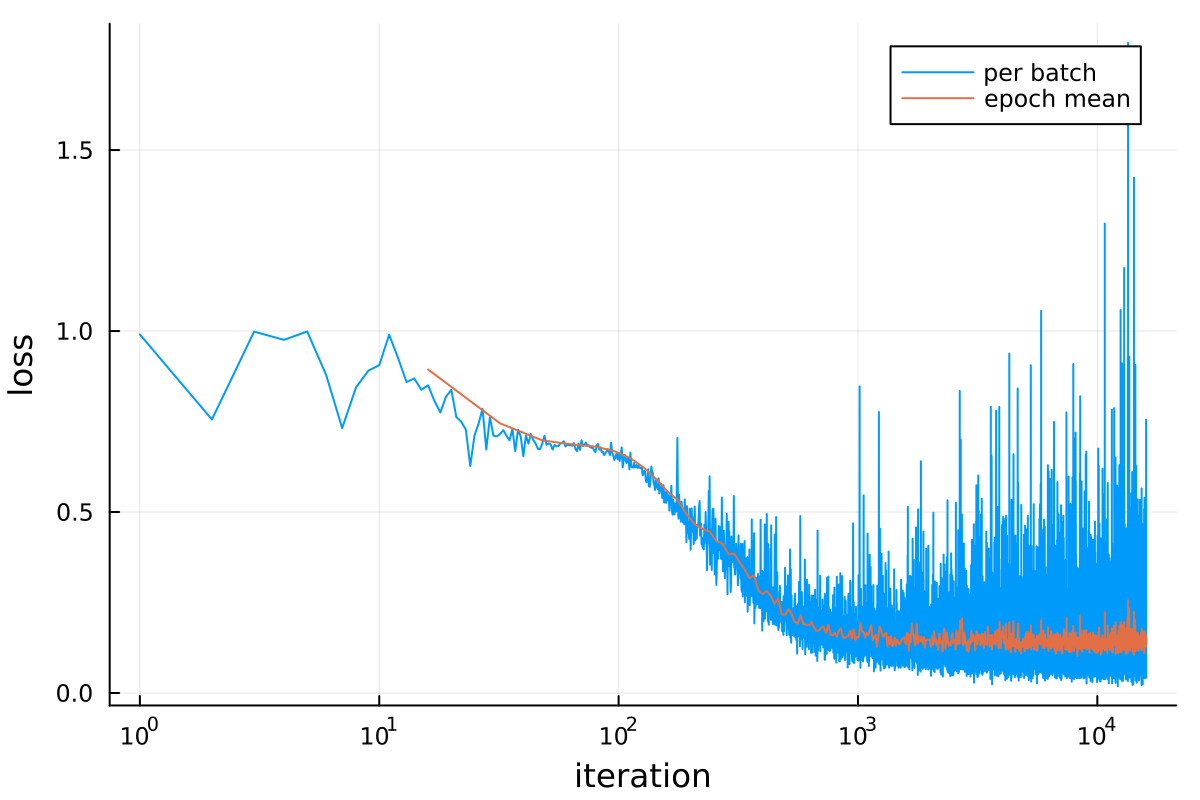

In [26]:
plot(loss_v; xaxis=(:log10, "iteration"),
    yaxis="loss", label="per batch")
n = length(loader)
@time plot!(n:n:length(loss_v), mean.(Iterators.partition(loss_v, n)),
    label="epoch mean", dpi=200)